![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re as re
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime
from itertools import combinations
from scipy.stats import ttest_ind
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [9]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [12]:
data.info()
data.sample(1)
data_for_changes=data.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [13]:
data.sample(5)
data_for_changes.sample(1)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
14691,id_5271,Paris,"['French', 'Bar', 'Pub']",5272.0,$$ - $$$,86.0,"[['Fab find', 'Friendly bar - good food'], ['0...",/Restaurant_Review-g187147-d8762711-Reviews-Le...,d8762711,1,4.0


In [14]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   


## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [15]:
# Количество отзывов
data['isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')
# заполняем пропуски средним по городу
mean = data.groupby('City')['Number of Reviews'].mean()
data['Number_of_Reviews'] = data[data['isNAN'] > 0].City.apply(lambda x: round(mean).loc[x])
data['Number of Reviews'].fillna(0, inplace=True)
data['Number_of_Reviews'].fillna(0, inplace=True)
data['Number of Reviews'] = data['Number of Reviews'] + data['Number_of_Reviews']
data.drop(['Number_of_Reviews'], axis = 1, inplace = True)

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [16]:
data.nunique(dropna=False)

Restaurant_id        13094
City                    31
Cuisine Style        10732
Ranking              12975
Price Range              4
Number of Reviews     1573
Reviews              41858
URL_TA               49963
ID_TA                49963
sample                   2
Rating                  10
isNAN                    2
dtype: int64

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing



 ### признак "Price Range"

In [17]:
display(data['Price Range'].unique())
data['Price Range'].value_counts()

array(['$$ - $$$', '$$$$', '$', nan], dtype=object)

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [18]:
# признак "Price Range"
data['isNAN'] = pd.isna(data['Price Range']).astype('uint8')
price_dict = {"$$$$": 3, "$$ - $$$": 2, "$": 1}
data['Price Range'] = data['Price Range'].replace(to_replace=price_dict)
# заполняем пропуски средним по городу
median = data.groupby('City')['Price Range'].median()
data['Price_Range'] = data[data['isNAN'] > 0].City.apply(lambda x: median.loc[x])
data['Price Range'].fillna(0, inplace=True)
data['Price_Range'].fillna(0, inplace=True)
data['Price Range'] = data['Price Range'] + data['Price_Range']
data.drop(['Price_Range'], axis = 1, inplace = True)

In [19]:
display(data['Price Range'].unique())
data['Price Range'].value_counts()

array([2., 3., 1.])

2.0    40402
1.0     7816
3.0     1782
Name: Price Range, dtype: int64

In [20]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          50000 non-null float64
Number of Reviews    50000 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
isNAN                50000 non-null uint8
dtypes: float64(4), int64(1), object(6), uint8(1)
memory usage: 4.2+ MB


In [21]:
# Cuisine Style: Кухня
data.loc[0, 'Cuisine Style']

"['Bar', 'Pub']"

In [22]:
# посчитаем количество представленных кухонь, если значение пустое, то кухня одна
def modify_cuisine_style(value):
    if pd.isnull(value):
        return []
    else:
        result = value.replace('[', '')
        result = result.replace(']', '')
        result = result.replace(', ', ',')
        return result.split(",")

data['Cuisine Style'] = data['Cuisine Style'].apply(modify_cuisine_style)
data['Cuisine_Style'] = data['Cuisine Style'].apply(lambda x: 1 if len(x)==0 else len(x))

In [23]:
data.info()
data.Restaurant_id.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        50000 non-null object
Ranking              50000 non-null float64
Price Range          50000 non-null float64
Number of Reviews    50000 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
isNAN                50000 non-null uint8
Cuisine_Style        50000 non-null int64
dtypes: float64(4), int64(2), object(6), uint8(1)
memory usage: 4.6+ MB


id_871      19
id_633      19
id_436      19
id_227      19
id_585      18
            ..
id_15128     1
id_15276     1
id_9031      1
id_11802     1
id_6906      1
Name: Restaurant_id, Length: 13094, dtype: int64

In [24]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data['city']=data['City'].copy()
data = pd.get_dummies(data, columns=[ 'city',], dummy_na=True)

In [25]:
#data_city.sample(2)

> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

# EDA 
Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.


### Посмотрим распределение признака

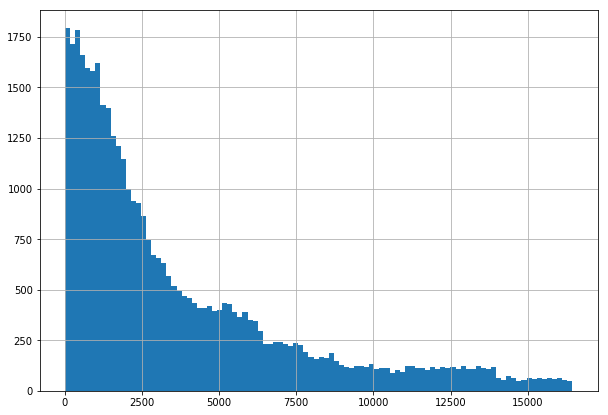

In [26]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

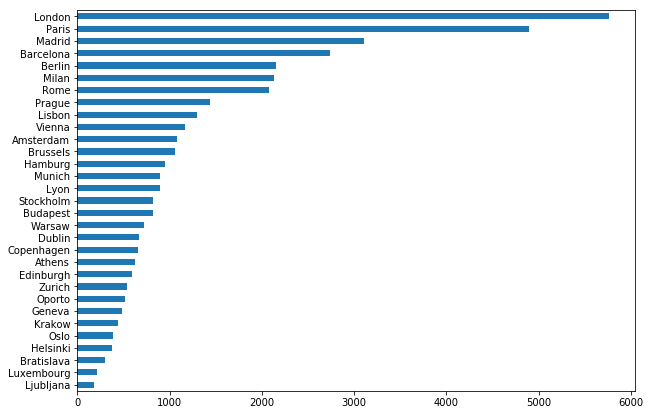

In [27]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

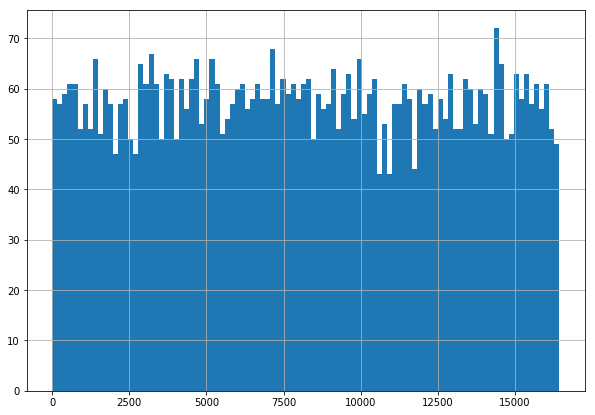

In [28]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

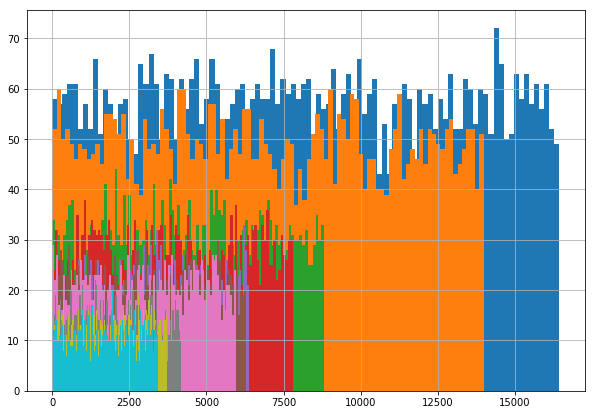

In [29]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

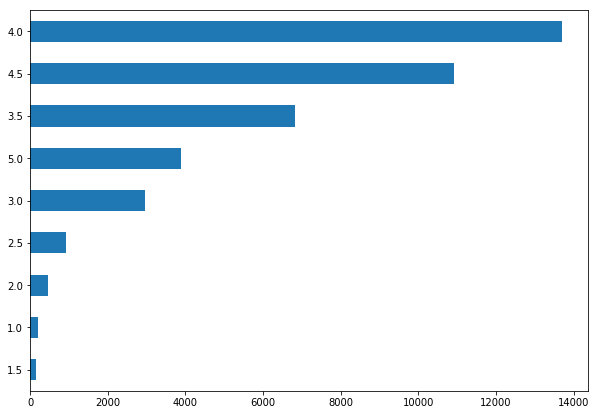

In [30]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

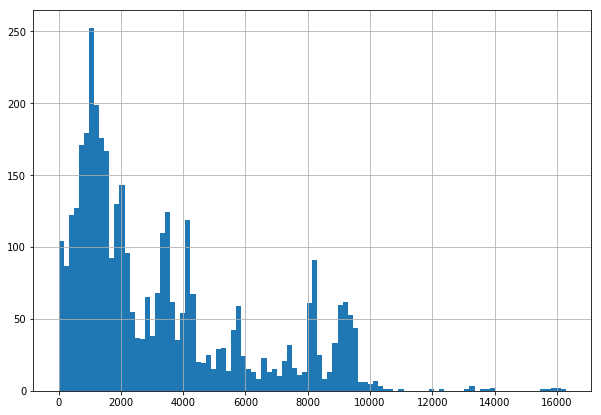

In [31]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

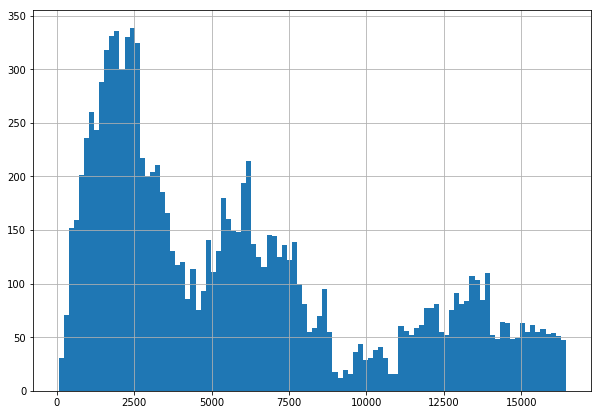

In [32]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

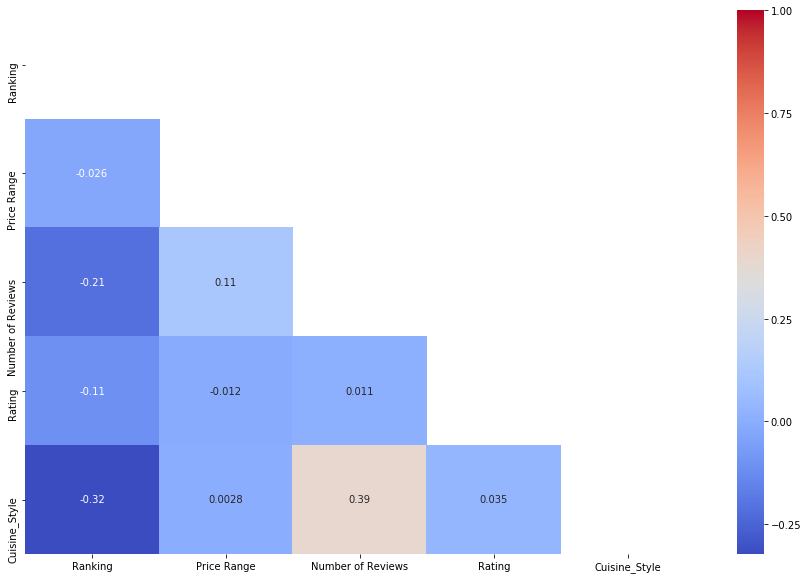

In [33]:
plt.rcParams['figure.figsize'] = (15,10)
data1=data[['Ranking','Price Range','Number of Reviews','Rating','Cuisine_Style']]
matrix = np.triu(data1.corr())
sns.heatmap(data1.corr(), annot=True, mask=matrix, cmap= 'coolwarm')

In [34]:
data.sample(10)
data_for_changes.sample(1)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
6760,id_6760,Paris,"['French', 'Cafe', 'European', 'Vegetarian Fri...",3127.0,$$ - $$$,629.0,"[['Good food, cozy ambiance!', 'Food good - at...",/Restaurant_Review-g187147-d786885-Reviews-Caf...,d786885,0,0.0




Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Мой блок

In [35]:
### Функции

#Функция для рассчета стат.величин и выбросов
#Для строковых столбцов
def plot_str(df,col):

    print('Распределение для столбца (не числовой):', col)
    fig,ax=plt.subplots()
    sns.countplot(df.loc[:,col], ax=ax)
    plt.show()
#поиск пустых  Nan значений в символьном  столбце, расчет процента потерянных значений
    n=100-(df[col].count()/df.shape[0]*100)
    print('уникальных значений ', len(df[col].dropna().unique()))
    print ('пустых значений,%', round(n,2))
    stud_math.score.unique()

#Для числовых столбцов
def plot_num (df,col_name, borders=None):
    sns.set(rc={'figure.figsize':(5, 5)})
    print('Распределение для столбца (числовой):', col_name)
    
    fig,ax=plt.subplots()
    df.loc[:,col_name].hist(ax=ax, bins=50)
    ax.set_xlabel(col_name)
    ax.set_ylabel('кол-во')
    plt.show()
    print (df[col_name].count())
    print (df.shape[0])

    n=100-(df[col_name].count()/df.shape[0]*100)
    print ('пустых значений,%', round(n,2))
    
    if borders is not None:
        print ('выбросы по условию ', borders)
        display(df[(~df.loc[:,col_name].between(borders[0],borders[1]))&pd.notnull(df.loc[:,col_name])])

#функция для рисования "усов"  
def get_boxplot(df,column):
    fig, ax = plt.subplots(figsize = (5, 5))
    sns.boxplot(x=column, y='score', 
                data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index[:30])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot для ' + column)
    plt.show()    
#Функция по расчету коэффициента стьюдента из 
def get_stat_dif(df,column):
    st_t=0
    cols = df.loc[:, column].value_counts(dropna =True).index[:30]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'Rating'], 
                        df.loc[df.loc[:, column] == comb[1], 'Rating']).pvalue <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            st_t=1
            
            break
    #print(st_t)   
    return st_t

# Добавление новых признаков

# Гипотезы:
1. Количество ресторанов в городе может влиять на оценку (чем более избалован клиент, тем строже оценивает)
2. Количество упоминаний кухни для каждого ресторана может косвенно свидетельствавть о ее популярности (наличие в ресторане популярных кухонь может сильно коррелировать с количеством отзывов и влиять на общую оценку ресторана
3. Наличие отзывов (булево, 1/0) может как говорить о популярности, так и о банальном отсутствии данных, нужно преверить способен ли данный признак улучшить модель
4. Наличие свежих отзывов: (количество дней от самого свежего отзыва до последнего отыва по каждому ресторану
5. Ранг ресторана/количество ресторанов в городе
6. Признак столицы (1/0)



#### 1. Количество ресторанов в городе. Данные из DataSet (подтверждается влияние на оценку):

In [36]:
rest_city_count=data.groupby('City')['Restaurant_id'].count().reset_index()
rest_city_count=rest_city_count.rename(columns={'Restaurant_id' : 'count_rest_in_city'})
#df = df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'})
print (rest_city_count)
data=pd.merge(data,rest_city_count, how='left', on='City')


          City  count_rest_in_city
0    Amsterdam                1372
1       Athens                 776
2    Barcelona                3395
3       Berlin                2705
4   Bratislava                 380
5     Brussels                1314
6     Budapest                1021
7   Copenhagen                 819
8       Dublin                 836
9    Edinburgh                 745
10      Geneva                 590
11     Hamburg                1186
12    Helsinki                 475
13      Krakow                 554
14      Lisbon                1647
15   Ljubljana                 222
16      London                7193
17  Luxembourg                 263
18        Lyon                1126
19      Madrid                3813
20       Milan                2694
21      Munich                1145
22      Oporto                 642
23        Oslo                 488
24       Paris                6108
25      Prague                1816
26        Rome                2589
27   Stockholm      

#### 5. Ранг/количество (Показатель ухудшает качество прогноза, на данном этапе не используем)

In [37]:
data['Rank_count']=data['Ranking']/data['count_rest_in_city']

### 3. Наличие отзывов (не улучшает модель. На данном этапе в обучающей выборке не используем)

In [38]:
type(data.loc[0,'Reviews'])

str

In [39]:
# Следует осуществить раяд преобразований в строке отзывов, чтобы добыть из нее нужную информацию
#1.
pattern = re.compile('\d+\/\d+\/\d+')
pat=re.compile("[\[\]\']")
rpattern=re.compile("\[\[(.+?)\]")

data['Reviews_only'] = data['Reviews'].apply(lambda i: re.sub(pat, '', str(i)))
data['Date_of_Reviews'] = data['Reviews'].apply(lambda i : re.findall(pattern,str(i)))
data['Reviews_only'] = data['Reviews'].apply(lambda i : re.findall(rpattern,str(i)))
#убираем список из отзывов
data['Reviews_only'] = data['Reviews_only'].apply(lambda x: ''.join(x))
#Чистим от мусора (кавычки)
data['Reviews_only']=data['Reviews_only'].apply(lambda x: x.replace("'",''))
data['Reviews_only']=data['Reviews_only'].apply(lambda x: x.replace("], [",''))


In [40]:
#Наличие отзывов о ресторане
cnt_rev_0 = data[data['Reviews_only']==''].groupby('Restaurant_id')['Reviews_only'].count().sort_values().reset_index()
cnt_rev_0=cnt_rev_0.rename(columns={'Reviews_only' : 'cnt_rev_0'})
data=pd.merge(data,cnt_rev_0, how='left', on='Restaurant_id')
data.cnt_rev_0=data.cnt_rev_0.fillna(0)

#### 4. Наличие свежих отзывов timedelta между последними отзывами (используем оба признака)

In [41]:
data['date_list']=data['Date_of_Reviews'].copy()
(data.Date_of_Reviews).apply( lambda x : len(x)).value_counts()



2    36202
0     8114
1     5680
3        4
Name: Date_of_Reviews, dtype: int64

Есть записи с 3 датами, хотя по условию отзывов должно быть не более 2. По-видимому, регулярное выражение вытащило дату из отзыва, 
соотсветственно в этих 4 случаях нужно взять только последние 2. Для исследования разницы между последними отзывами, используем только последнюю дату (len(list)-1). 
### Вывод: 
Оба признака:
- разница между датами послених отзывов (пропуски - нули)
- разница между датой самого свежего отзыва и последним отзывом по ресторану (пропуски - медиана) 
используем для обучения модели, т.к. их включение в модель позволило снизить ошибку.

In [42]:
#Блок обработки строки отзывыов, преобразование: получение отдельного отзыва и дат двух последних отзывов:

for n, dat in enumerate(data.Date_of_Reviews):
    first_date=''
    last_date=''        
# Обрабатываем список строк, превращая его в список дат
    if len(dat)>1:
        local_dates=[]
        for d in dat:

            if pd.isna(d)==False:
                try:
                    d=datetime.datetime.strptime(d, '%m/%d/%Y')
                    local_dates.append(d)
                except:
                    print ('1 ошибка преобразования, значение: ', d,' в строке  ',n, 'формат %d%m%Y прогоняем снова')
                    try:
                        d=datetime.datetime.strptime(d, '%d/%m/%Y')
                        local_dates.append(d)
                        
                    except:
                        print ('2 ошибка преобразования, значение: ', d,' в строке  ',n, 'формат %d%m%y прогоняем снова')
                        try:
                            d=datetime.datetime.strptime(d, '%d/%m/%y')
                            local_dates.append(d)
                        except:    
                            print ('3 ну теперь-то точно не получается: ошибка преобразования, значение: ', d,' в строке  ',n)

        data.at[n,'date_list']=sorted(list(local_dates))

    else: 
        data.at[n,'date_list']=[]

#Получаем более ранюю дату и последнюю дату, выносим их в отдельные столбцы      
        
data['first_date']=data['date_list'].apply(lambda x: x[-2] if len(x)>1 else None)  
data['last_date']=data['date_list'].apply(lambda x: x[-1] if len(x)>1 else None)

# Получаем разницу двух последних отзывов
data ['delta_days_rev']=data['last_date']-data['first_date']
data ['delta_days_rev']=data['delta_days_rev'].apply(lambda x: x.days if pd.notna(x)  else None)

#Заполняем пропущенные значения нулями, проверяем, уличшится ли модель (лучше всего отреагировала на 0)
data ['delta_days_rev']=data ['delta_days_rev'].fillna(0)

#И средним значением:
#data ['delta_days_rev']=data ['delta_days_rev'].fillna(data ['delta_days_rev'].mean()) #стало чуть хуже
#И медианой:
#data ['delta_days_rev']=data ['delta_days_rev'].fillna(data ['delta_days_rev'].median()) #стало еще хуже, оставляем 0

#Находим  дату самого позднего отзыва

last_date_rev=data['last_date'].max()

#Делаем еще один признак: разница в днях последнего отзыва по ресторану и вообще последнего отзыва (лучше всего пропуски заполнить медианой, есть улучшение качества модели)

data ['delta_days_last_rev']=last_date_rev-data['last_date']
data ['delta_days_last_rev']=data ['delta_days_last_rev'].apply(lambda x: x.days if pd.notna(x)  else None)

data ['delta_days_last_rev']=data ['delta_days_last_rev'].fillna(data ['delta_days_last_rev'].median())


1 ошибка преобразования, значение:  21/10/17  в строке   2221 формат %d%m%Y прогоняем снова
2 ошибка преобразования, значение:  21/10/17  в строке   2221 формат %d%m%y прогоняем снова
1 ошибка преобразования, значение:  30/5/2017  в строке   3809 формат %d%m%Y прогоняем снова
1 ошибка преобразования, значение:  29/9/2016  в строке   33348 формат %d%m%Y прогоняем снова


## Количество упоминаний кухни (популярность)?
Выбираем все кухни в один список, считаем количество упоминаний. Находим вес колтичества упоминаний в общем количестве упоминаний каждой кухни. Получаем метрику предполагаемой популярности ресторана на основании популярности каждой кухни: складываем веса.

### Вывод:
Новый признак увеличил "шум" и снизи качество модели, не используем.


In [43]:
#Заполняем пустые значения списка значемем "mixed" (смешанная кухня)

for i, val in enumerate(data['Cuisine Style']):
    Tlist=[]
    if len (val) <1: 
        data.at[i,'Cuisine Style']=['mixed']
        

In [44]:
#получаем список всех кухонь. 
data['Cuisine Style']=data['Cuisine Style'].fillna('some_cusine')

c_list=",".join(list(data['Cuisine Style'].apply(lambda x: ','.join(x)))).split(',')
#преобразуем в DataFrame
cusine_list=pd.DataFrame(c_list)

cusine_list.columns = ['Cuisine Style']

#получаем количество упоминаний
cusine_list = cusine_list['Cuisine Style'].value_counts().reset_index()
cusine_list.columns=['Cuisine Style','cnt']

#считаем общее количество упоминаний
total_count=cusine_list.cnt.sum()

#Считаем "Вес" каждой кухни (популярность)
cusine_list['Weight']=cusine_list['cnt']/total_count*100
TTcuisine=data[['Restaurant_id','Cuisine Style']].copy()
TTcuisine=TTcuisine.explode('Cuisine Style')
TTcuisine=TTcuisine.merge(cusine_list, how='left', on ='Cuisine Style')
TTcuisine=TTcuisine.groupby('Restaurant_id')['Weight'].sum().reset_index()
TTcuisine.columns=['Restaurant_id','Weight']

In [45]:
data=data.merge(TTcuisine, how='left', on = 'Restaurant_id' )
data['Weight_cusine']=data['Weight']/data['Cuisine_Style']
display(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 57 columns):
Restaurant_id          50000 non-null object
City                   50000 non-null object
Cuisine Style          50000 non-null object
Ranking                50000 non-null float64
Price Range            50000 non-null float64
Number of Reviews      50000 non-null float64
Reviews                49998 non-null object
URL_TA                 50000 non-null object
ID_TA                  50000 non-null object
sample                 50000 non-null int64
Rating                 50000 non-null float64
isNAN                  50000 non-null uint8
Cuisine_Style          50000 non-null int64
city_Amsterdam         50000 non-null uint8
city_Athens            50000 non-null uint8
city_Barcelona         50000 non-null uint8
city_Berlin            50000 non-null uint8
city_Bratislava        50000 non-null uint8
city_Brussels          50000 non-null uint8
city_Budapest          50000 non-null uin

None

#### Добавим дополнительный признак: Столица (да/нет) Данные берем из географического атласа)))
Модель отреагировала увеличением ошбики на признак Столица, но хорошо на признак ограничения (большой город/небольшой город) эмпирически установлен порог - 500000 населения

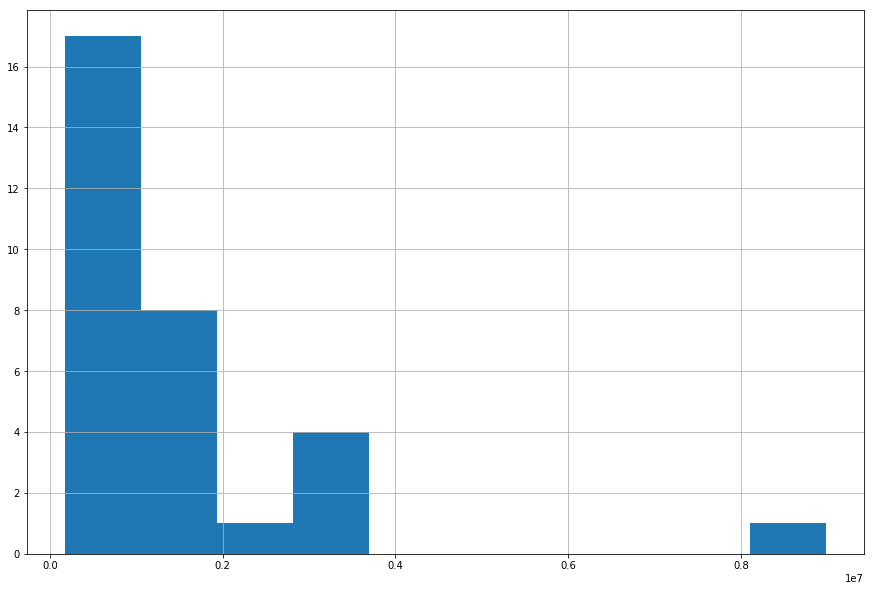

In [46]:
#Составляем DataFrame с признаком "Столица"  инаселение (С сайта https://ec.europa.eu/eurostat/data/database)
data.City.unique()
Capital=pd.DataFrame([['Paris', 1, 2160928], ['Helsinki',1,656229 ], ['Edinburgh',0,482005], ['London',1,8982256], ['Bratislava',1,437726 ], ['Lisbon',1,505526 ],
       ['Budapest',1,1752286], ['Stockholm',1,975551], ['Rome',1,2873494], ['Milan',0,1399860  ], ['Munich',0,1471508], ['Hamburg',0,1841179],
       ['Prague',1,1308632], ['Vienna',1,1897491 ], ['Dublin',0,544107 ], ['Barcelona',1,1636762 ], ['Brussels',1,174383 ], ['Madrid',1,3223334],
       ['Oslo',1,634293 ], ['Amsterdam',1,873555 ], ['Berlin',1,3644826 ], ['Lyon',0,513275], ['Athens',1,3167000 ], ['Warsaw',1,1764615],
       ['Oporto',0,214349], ['Krakow',0,766683], ['Copenhagen',1, 794128 ], ['Luxembourg',1,613894 ], ['Zurich',0,402762], ['Geneva',1,499480 ],
       ['Ljubljana',1,295504]])
Capital.columns=['City','Capital','Population']
Capital['Population'].hist()

In [47]:
#Добавляем признак крупного города: более 500000 населения
Capital['more500']=Capital.Population.apply(lambda x: 1 if x>500000 else 0)

In [48]:
#Чистим города от кавычек:
data.City=data.City.apply(lambda x: x.replace("'",''))
data=data.merge(Capital, how='left',on='City')
data['popul_rest']=data['count_rest_in_city']/data['Population']
data

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,first_date,last_date,delta_days_rev,delta_days_last_rev,Weight,Weight_cusine,Capital,Population,more500,popul_rest
0,id_0,Paris,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,NaT,NaT,0.0,136.0,376.330504,188.165252,1,2160928,1,0.002827
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,2017-10-29,2017-12-05,37.0,83.0,278.012585,55.602517,1,656229,1,0.000724
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,...,2017-12-06,2017-12-28,22.0,60.0,340.110920,340.110920,0,482005,0,0.001546
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,...,2017-11-22,2017-12-06,14.0,82.0,288.434934,57.686987,1,8982256,1,0.000801
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,...,2018-01-24,2018-02-08,15.0,18.0,414.119422,69.019904,1,437726,0,0.000868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,2.0,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,...,2017-11-12,2017-12-16,34.0,72.0,244.546189,61.136547,0,1399860,1,0.001924
49996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,2.0,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,...,2017-12-12,2017-12-21,9.0,67.0,38.052504,7.610501,1,2160928,1,0.002827
49997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,2.0,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,...,2008-04-12,2016-11-03,3127.0,480.0,106.768699,53.384349,1,975551,1,0.001059
49998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,2.0,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,...,2017-06-18,2017-07-11,23.0,230.0,124.886871,24.977374,1,1764615,1,0.000524


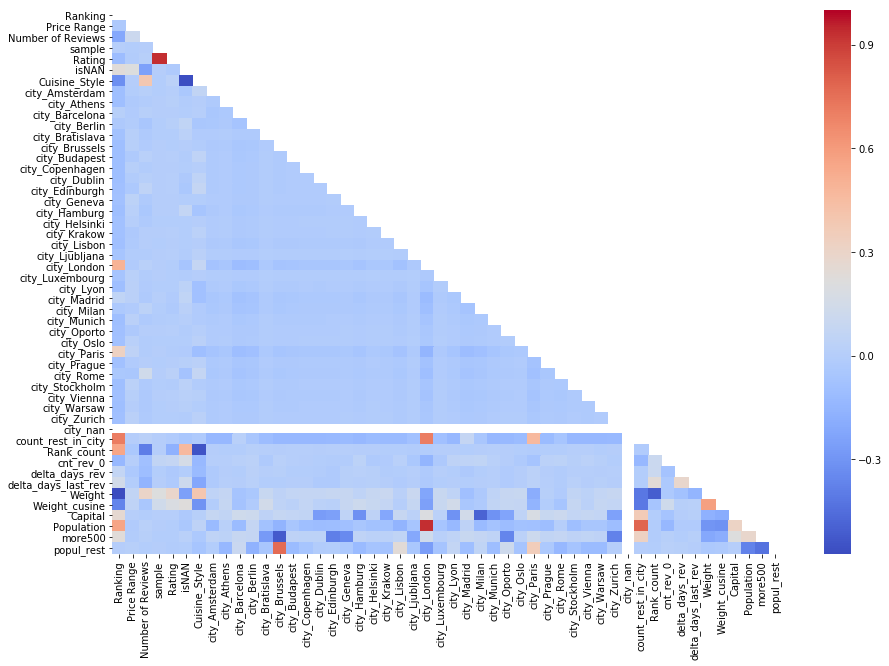

In [49]:
dt=data.groupby('Restaurant_id')['City'].count()

plt.rcParams['figure.figsize'] = (15,10)

matrix = np.triu(data.corr())
sns.heatmap(data.corr(), annot=False, mask=matrix, cmap= 'coolwarm')

## EDA
Простым перебором признаков не удалось получить ощутимое увеличение качества модели. Без EDA все-таки не обойтись.

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 61 columns):
Restaurant_id          50000 non-null object
City                   50000 non-null object
Cuisine Style          50000 non-null object
Ranking                50000 non-null float64
Price Range            50000 non-null float64
Number of Reviews      50000 non-null float64
Reviews                49998 non-null object
URL_TA                 50000 non-null object
ID_TA                  50000 non-null object
sample                 50000 non-null int64
Rating                 50000 non-null float64
isNAN                  50000 non-null uint8
Cuisine_Style          50000 non-null int64
city_Amsterdam         50000 non-null uint8
city_Athens            50000 non-null uint8
city_Barcelona         50000 non-null uint8
city_Berlin            50000 non-null uint8
city_Bratislava        50000 non-null uint8
city_Brussels          50000 non-null uint8
city_Budapest          50000 non-null uin

Распределение для столбца (числовой): Ranking


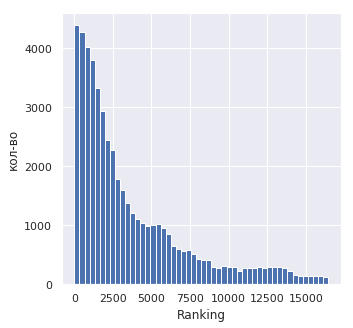

50000
50000
пустых значений,% 0.0
Распределение для столбца (числовой): Price Range


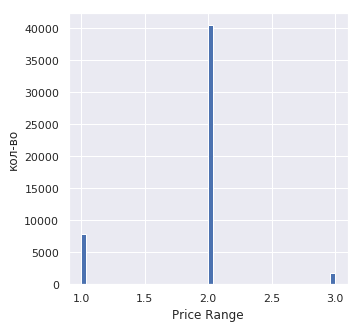

50000
50000
пустых значений,% 0.0
Распределение для столбца (числовой): Number of Reviews


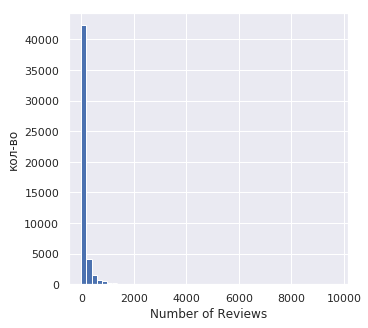

50000
50000
пустых значений,% 0.0
Распределение для столбца (числовой): sample


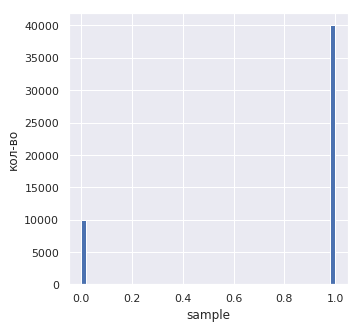

50000
50000
пустых значений,% 0.0
Распределение для столбца (числовой): Rating


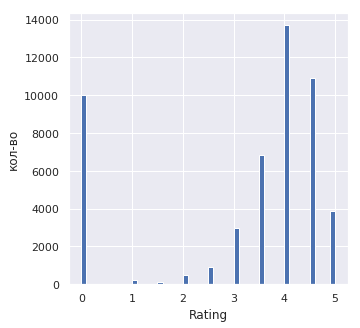

50000
50000
пустых значений,% 0.0
Распределение для столбца (числовой): isNAN


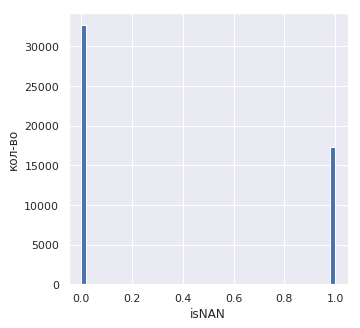

50000
50000
пустых значений,% 0.0
Распределение для столбца (числовой): Cuisine_Style


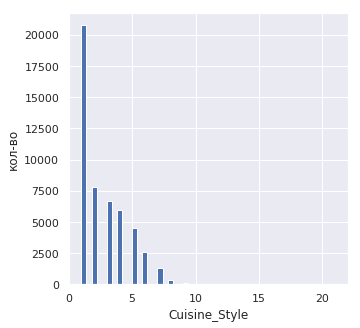

50000
50000
пустых значений,% 0.0
Распределение для столбца (числовой): count_rest_in_city


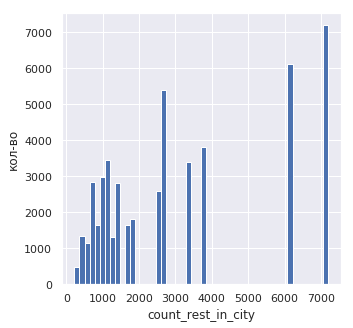

50000
50000
пустых значений,% 0.0
Распределение для столбца (числовой): Rank_count


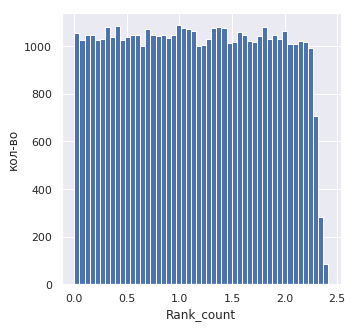

50000
50000
пустых значений,% 0.0
Распределение для столбца (числовой): cnt_rev_0


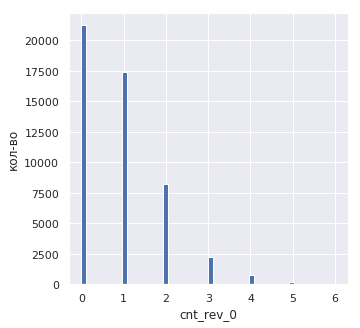

50000
50000
пустых значений,% 0.0
Распределение для столбца (числовой): delta_days_rev


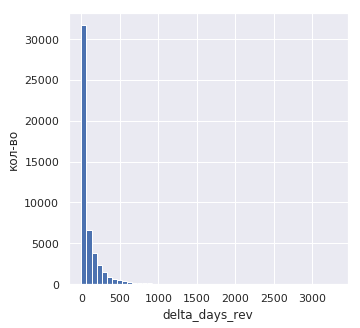

50000
50000
пустых значений,% 0.0
Распределение для столбца (числовой): delta_days_last_rev


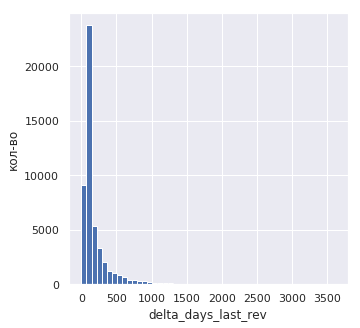

50000
50000
пустых значений,% 0.0
Распределение для столбца (числовой): Weight


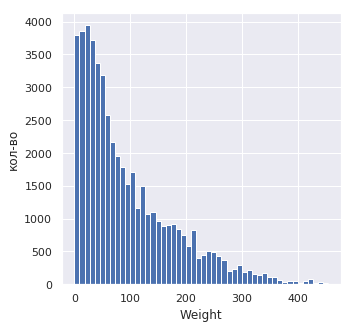

50000
50000
пустых значений,% 0.0
Распределение для столбца (числовой): Weight_cusine


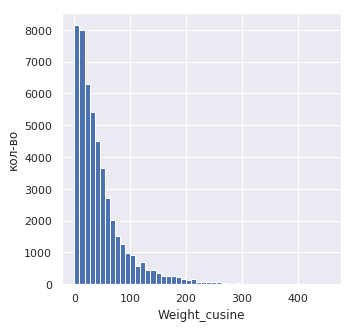

50000
50000
пустых значений,% 0.0
Распределение для столбца (числовой): Capital


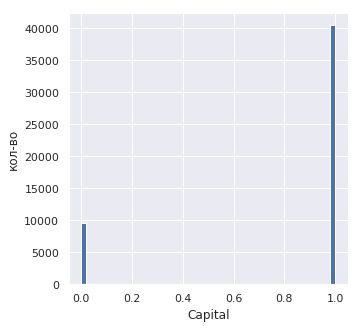

50000
50000
пустых значений,% 0.0
Распределение для столбца (числовой): Population


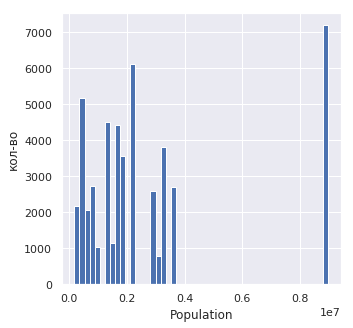

50000
50000
пустых значений,% 0.0
Распределение для столбца (числовой): more500


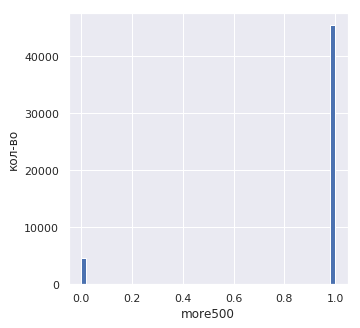

50000
50000
пустых значений,% 0.0
Распределение для столбца (числовой): popul_rest


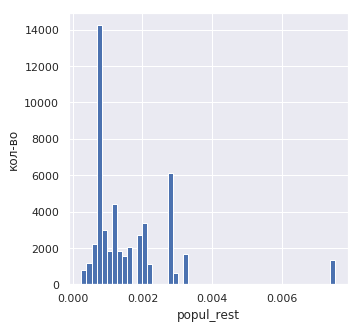

50000
50000
пустых значений,% 0.0


In [51]:
#формируем список столбцов с числовыми значениями
numbers_colmn_list=(data.select_dtypes(include=[np.number])).columns.values.tolist()
numbers_colmn_list
#распределение цифровых столбцов
for column in numbers_colmn_list:
    borders=None
    if column[0:4]=='city':
        continue
    
    plot_num(data,column,borders)

Выводы.
Прослеживается закономерность в распределении численности населения: версия с разделением на сегменты по признаку чилсленность населения более 500т выглядит правдоподобно. Есть смысл сегментировать признак и использовать его при построении модели (more500)
Вес каждой кухни и средний вес популярности (как сумма весов/количество кухонь) кухни не повлиял в лучшую сторону на качество модели, но сбрасывать его со счетов пока что не стоит.  
Признак "Количество ресторанов в городе" (count_rest_in_city) можно попытаться также сегментировать (count_rest_in_city_segm=1 (более 0,0006) (т.к. количество ресторанов сильно зависит от размера города) и оценить результат.
Также можно проверить комбинацию сегментированных (count_rest_in_city_segm, more500)  и несегментированных (count_rest_in_city, population) признаков (проверено, незначительное снижение ошбики дает использование "чистых" значений, без признака сегмента).
По признакам, так или иначе связанным с размером города: Рапределение смещено, можно попробовать нормализовать распределение и оценить результат.



In [52]:
data['count_rest_in_city_segm']=data['popul_rest'].apply(lambda x: 1 if x>0.006 else 0)
#преобразуем id:
data['Restaurant_id_num']=data['Restaurant_id'].apply(lambda x: int(x.replace('id_','')))

Посмотрим на выбросы, попробуем заменить на среднее значение даты:

In [53]:
q=data.delta_days_rev.describe()
#print(q)
#low=q[4]-1.5*(q[6]-q[4])
#up=q[6]+1.5*(q[6]-q[4])
                                
#mid_value=data.delta_days_rev.mean()

#print (up, low, mid_value)
data[~data.delta_days_rev.between(q[4]-1.5*(q[6]-q[4]),q[6]+1.5*(q[6]-q[4]))&pd.notnull(data.loc[:,'delta_days_rev'])]
#data.delta_days_rev=data.delta_days_rev.apply(lambda x: mid_value if x==0 else x)
#data.info()


#положительного результата замена не дала

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,delta_days_rev,delta_days_last_rev,Weight,Weight_cusine,Capital,Population,more500,popul_rest,count_rest_in_city_segm,Restaurant_id_num
13,id_13,Hamburg,[mixed],1000.0,2.0,30.0,"[['Surprisingly good pizza', 'Yummy'], ['09/28...",/Restaurant_Review-g187331-d1344523-Reviews-Il...,d1344523,0,...,374.0,151.0,297.539348,297.539348,0,1841179,1,0.000644,0,13
22,id_22,Barcelona,"['Mediterranean', 'Spanish', 'Vegetarian Frien...",2853.0,2.0,71.0,"[['Amazing', 'Loved It!!!!'], ['09/24/2017', '...",/Restaurant_Review-g187497-d1216215-Reviews-La...,d1216215,0,...,797.0,155.0,302.314385,100.771462,1,1636762,1,0.002074,0,22
47,id_47,Paris,"['French', 'Fusion']",3859.0,2.0,144.0,"[['Good food', 'complete satisfaction'], ['11/...",/Restaurant_Review-g187147-d1336377-Reviews-La...,d1336377,0,...,648.0,474.0,304.430698,152.215349,1,2160928,1,0.002827,0,47
56,id_56,London,"['Indian', 'Asian']",13559.0,2.0,13.0,"[['Dinner', ""Mum's 80th Birthday Surprise Lunc...",/Restaurant_Review-g186338-d4919094-Reviews-Bl...,d4919094,0,...,330.0,278.0,251.417732,125.708866,1,8982256,1,0.000801,0,56
92,id_92,Paris,['Italian'],5317.0,1.0,49.0,"[['Sad restaurant', 'Well worth trying'], ['07...",/Restaurant_Review-g187147-d1337474-Reviews-Il...,d1337474,0,...,776.0,230.0,302.437036,302.437036,1,2160928,1,0.002827,0,92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49960,id_3989,Prague,"['European', 'Czech']",4000.0,2.0,3.0,"[['Time saver for the castle', 'Tourist trap.....",/Restaurant_Review-g274707-d7653680-Reviews-Ca...,d7653680,1,...,632.0,164.0,43.545930,21.772965,1,1308632,1,0.001388,0,3989
49963,id_562,Milan,"['Japanese', 'Sushi', 'Fusion', 'Vegetarian Fr...",563.0,2.0,360.0,"[['You know what you get', 'High level sushi i...",/Restaurant_Review-g187849-d2344726-Reviews-Mi...,d2344726,1,...,422.0,323.0,194.454771,48.613693,0,1399860,1,0.001924,0,562
49993,id_6057,Paris,[mixed],6058.0,2.0,16.0,"[['Naught but VERY nice', 'Yum'], ['01/23/2017...",/Restaurant_Review-g187147-d10532509-Reviews-B...,d10532509,1,...,342.0,57.0,27.736809,27.736809,1,2160928,1,0.002827,0,6057
49997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,2.0,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,...,3127.0,480.0,106.768699,53.384349,1,975551,1,0.001059,0,1649


Ну и последняя попытка сделать модель лучше: 
1. Определим значимые категориальные признаки с попощью теста Стьюдента (процедура из предыдущего юнита)
2. Убираем столбцы, пусть значимые, но создающие шум. Оцениваем результат после каждого удаленного столбца.

In [54]:
#data.info()
not_st_list=[]
st_list=[]
data.sample()
#data=data.drop(['Reviews','URL_TA'], axis=1)
numbers_colmn_list=['Reviews','Number of Reviews','delta_days_rev','delta_days_last_rev','Restaurant_id_num','Cuisine Style','Rating','Date_of_Reviews','date_list']
                    #'Weight','Weight_cusine','Population','popul_rest',
for colum in data.columns:
    #print (colum)
    if colum not in numbers_colmn_list :    
        st_t=get_stat_dif(data,colum)
        #print(st_t)
        if st_t==1: st_list.append(colum)
for colum in data.columns:
#    print(colum[0:3])
    if colum not in st_list and colum[0:3]=='cit':
        
        not_st_list.append(colum)
not_st_list        

Найдены статистически значимые различия для колонки City
Найдены статистически значимые различия для колонки Price Range
Найдены статистически значимые различия для колонки URL_TA
Найдены статистически значимые различия для колонки ID_TA
Найдены статистически значимые различия для колонки sample
Найдены статистически значимые различия для колонки isNAN
Найдены статистически значимые различия для колонки Cuisine_Style
Найдены статистически значимые различия для колонки city_Athens
Найдены статистически значимые различия для колонки city_Berlin
Найдены статистически значимые различия для колонки city_Madrid
Найдены статистически значимые различия для колонки city_Milan
Найдены статистически значимые различия для колонки city_Oporto
Найдены статистически значимые различия для колонки city_Rome
Найдены статистически значимые различия для колонки city_Stockholm
Найдены статистически значимые различия для колонки city_Vienna
Найдены статистически значимые различия для колонки count_rest_in_c

['city_Amsterdam',
 'city_Barcelona',
 'city_Bratislava',
 'city_Brussels',
 'city_Budapest',
 'city_Copenhagen',
 'city_Dublin',
 'city_Edinburgh',
 'city_Geneva',
 'city_Hamburg',
 'city_Helsinki',
 'city_Krakow',
 'city_Lisbon',
 'city_Ljubljana',
 'city_London',
 'city_Luxembourg',
 'city_Lyon',
 'city_Munich',
 'city_Oslo',
 'city_Paris',
 'city_Prague',
 'city_Warsaw',
 'city_Zurich',
 'city_nan']

Cоздаем модель на основании теста Стьюдента (только он)
Результат валидации (ошибка) немного ухудшился, в таком виде модель использовать не стоит. Но можно попробовать изменить предыдущую модель с учотом значимости признаков (по тесту)
1. Выделим числовую часть из признака ID_TA


In [55]:
data['id_ta']=data.ID_TA.apply(lambda x: int(x[1:]))
data.sample(2)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,delta_days_last_rev,Weight,Weight_cusine,Capital,Population,more500,popul_rest,count_rest_in_city_segm,Restaurant_id_num,id_ta
26045,id_317,Luxembourg,['Italian'],318.0,1.0,14.0,"[['Really weird experience', ""Luxembourg's bes...",/Restaurant_Review-g190356-d7723145-Reviews-At...,d7723145,1,...,307.0,205.925373,205.925373,1,613894,1,0.000428,0,317,7723145
28762,id_347,Oslo,"['Italian', 'Mediterranean']",348.0,2.0,18.0,"[['Awesome Italian food, great Service, lovel....",/Restaurant_Review-g190479-d10785584-Reviews-A...,d10785584,1,...,184.0,231.638048,115.819024,1,634293,1,0.000769,0,347,10785584


In [56]:
data_st=data[st_list+['Number of Reviews','delta_days_rev','delta_days_last_rev','Restaurant_id_num','Rating']]
data_st.info()
data_st.sample(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 26 columns):
City                   50000 non-null object
Price Range            50000 non-null float64
URL_TA                 50000 non-null object
ID_TA                  50000 non-null object
sample                 50000 non-null int64
isNAN                  50000 non-null uint8
Cuisine_Style          50000 non-null int64
city_Athens            50000 non-null uint8
city_Berlin            50000 non-null uint8
city_Madrid            50000 non-null uint8
city_Milan             50000 non-null uint8
city_Oporto            50000 non-null uint8
city_Rome              50000 non-null uint8
city_Stockholm         50000 non-null uint8
city_Vienna            50000 non-null uint8
count_rest_in_city     50000 non-null int64
cnt_rev_0              50000 non-null float64
Weight                 50000 non-null float64
Weight_cusine          50000 non-null float64
Population             50000 non-null int64


,City,Price Range,URL_TA,ID_TA,sample,isNAN,Cuisine_Style,city_Athens,city_Berlin,city_Madrid,...,cnt_rev_0,Weight,Weight_cusine,Population,popul_rest,Number of Reviews,delta_days_rev,delta_days_last_rev,Restaurant_id_num,Rating
14817,Rome,2.0,/Restaurant_Review-g187791-d1207928-Reviews-Th...,d1207928,1,0,5,0,0,0,...,0.0,259.899746,51.979949,2873494,0.000901,5927.0,2.0,48.0,144,4.5


по рузультату теста выявлено, что данные по некоторым городам вообще не влияют на результат. Попробуем убрать эти столбцы из выборки.

# Data Preprocessing

In [57]:
#df_preproc = data[['Ranking','Price Range','Number of Reviews','Rating','Cuisine_Style','sample','count_rest_in_city','delta_days_rev','delta_days_last_rev','Weight']]
df_preproc=data.copy()
#df_preproc=df_preproc.drop()
df_preproc = df_preproc.drop(['Restaurant_id','Restaurant_id_num','Cuisine Style', 'Reviews', 'URL_TA', 'ID_TA', 'Reviews_only',
    'Date_of_Reviews','date_list','first_date','last_date','Weight','Weight_cusine','Capital','more500',]+not_st_list  , axis=1) 
#df_preproc = df_preproc.drop(['URL_TA','ID_TA'], axis=1)
#'
#'Rank_count','count_rest_in_city_segm','popul_rest','more500','cnt_rev_0''Restaurant_id','Reviews_only''Date_of_Reviews','date_list','first_date','last_date'
df_preproc = df_preproc.drop(['City'], axis=1)

# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [58]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 24 columns):
Ranking                    50000 non-null float64
Price Range                50000 non-null float64
Number of Reviews          50000 non-null float64
sample                     50000 non-null int64
Rating                     50000 non-null float64
isNAN                      50000 non-null uint8
Cuisine_Style              50000 non-null int64
city_Athens                50000 non-null uint8
city_Berlin                50000 non-null uint8
city_Madrid                50000 non-null uint8
city_Milan                 50000 non-null uint8
city_Oporto                50000 non-null uint8
city_Rome                  50000 non-null uint8
city_Stockholm             50000 non-null uint8
city_Vienna                50000 non-null uint8
count_rest_in_city         50000 non-null int64
Rank_count                 50000 non-null float64
cnt_rev_0                  50000 non-null float64
delta_days_rev 

In [59]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [60]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 23), (40000, 23), (40000, 22), (32000, 22), (8000, 22))

# Model 
Сам ML

In [61]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [62]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [63]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred

# округлим данные
# Округляем результаты с точностью 0.5

def rating_round(x, base=0.5):
    return base * round(x/base)

def predict(ds):
    return np.array([rating_round(x) for x in model.predict(ds)])

y_pred = predict(X_test)

y_pred1 = model.predict(X_test)
#np.round(y_predict * 2)/2

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [64]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MAE без округления:', metrics.mean_absolute_error(y_test, y_pred1))

MAE: 0.170125
MAE без округления: 0.20395375


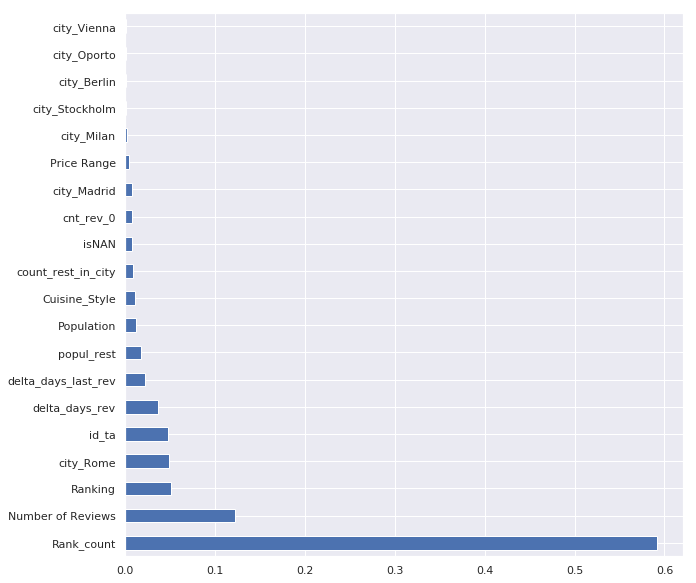

In [65]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

# Выводы. 
Работа интересная, позволяет прощупать руками признаки и их влияние на оценку. Первое знакомство с ML.
На данном этапе обучения движения в направлении улучшения качества модели выглядят несколько хаотичными с большим количеством ручных переборов и догадок. 

### Что сделано: 
1. Найдены дополнительные признаки, улучшающие качество модели (количство населения города,разница между датами отзывов, и т.д.
2. Были попытки создать дополнительные признаки, окончившиеся неудачно (по причине негативного влияния на модель): признак столицы, вес (популярность) видов кухни.
3. Была попытка провеси сегментацию городов, которая оказалась практически бесполезной (не включено в модель)
4. Наилучший резульат был получен с учетом данных полученных в результате расчета коэффициента Стьюдента для каждого из признаков.

### Что НЕ сделано (по причине отстутсвия времени и опыта), но могло боы повлиять на качество модели:
1. Провести более качественную сегментацию ресторанов на основании нескольких признаков.
2. Проанализировать отзывы: 
- тональность (положительный или отрицательный)
- поиск ключевых слов, которые могут косвенно свидтельствовать о положительности отзыва
3. Загрузить дополнительные данные с tripadwisor (место? координаты?) (нет опыта парсинга, вообще не знаю, как это делать)
4. Поскольку подбор параметров и их комбинаций на данный момент - результат по большей части "наудачу", проводится вручную и является, по сути, перебором полей, предположительно можно автоматизировать процесс поиска наиболее удачных комбинаций и их количестваю, приводящих к минимизации ошибки.


# Submission
Если все устраевает - готовим Submission на кагл

In [66]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,isNAN,Cuisine_Style,city_Athens,city_Berlin,city_Madrid,city_Milan,...,city_Vienna,count_rest_in_city,Rank_count,cnt_rev_0,delta_days_rev,delta_days_last_rev,Population,popul_rest,count_rest_in_city_segm,id_ta
3037,5867.0,2.0,25.0,0.0,1,1,0,0,0,0,...,0,6108,0.960544,0.0,163.0,169.0,2160928,0.002827,0,12006211
9353,678.0,3.0,183.0,0.0,0,6,0,0,0,0,...,0,3395,0.199705,1.0,28.0,94.0,1636762,0.002074,0,9809738
4446,3911.0,1.0,108.0,0.0,0,2,0,0,0,0,...,0,2589,1.510622,0.0,0.0,136.0,2873494,0.000901,0,4503959
427,1046.0,2.0,67.0,0.0,1,1,0,0,0,0,...,0,925,1.130811,1.0,0.0,136.0,1764615,0.000524,0,12362395
6687,4564.0,2.0,37.0,0.0,1,1,0,0,0,0,...,0,3395,1.344330,1.0,0.0,136.0,1636762,0.002074,0,5775941
7041,3280.0,2.0,85.0,0.0,0,5,0,0,0,0,...,0,1647,1.991500,0.0,217.0,142.0,505526,0.003258,0,8058337
1914,7479.0,2.0,2.0,0.0,1,1,0,0,0,0,...,0,3395,2.202946,0.0,0.0,136.0,1636762,0.002074,0,11903522
9774,845.0,2.0,21.0,0.0,0,5,0,0,0,0,...,0,1372,0.615889,0.0,20.0,59.0,873555,0.001571,0,11829815
3329,9691.0,1.0,10.0,0.0,0,1,0,0,0,0,...,0,7193,1.347282,0.0,32.0,111.0,8982256,0.000801,0,8436666
7929,1884.0,2.0,15.0,0.0,1,2,0,0,0,0,...,0,819,2.300366,0.0,88.0,296.0,794128,0.001031,0,1012041


In [67]:
test_data = test_data.drop(['Rating'], axis=1)

In [68]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [69]:
predict_submission = predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [70]:
predict_submission

array([3. , 4. , 4. , ..., 3. , 4.5, 4. ])

In [71]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.0
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.5
7,id_7,2.5
8,id_8,4.0
9,id_9,4.5


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
